In [6]:
from river.datasets import Insects
from river.datasets import synth
from clustream import CluStream
from river import drift
import math
import numpy as np
import matplotlib.pyplot as plt
from river.utils import dict2numpy
from scipy.spatial import distance_matrix
from time import time

In [7]:
dataset = Insects('incremental_balanced')


In [8]:
learner = CluStream(n_macro_clusters=6,max_micro_clusters=60,time_window=500)
test = drift.PageHinkley(100,delta=0.05,threshold=30,alpha= 0.9999,mode='both')



In [9]:
def get_mean_dist(learner):
    ## Calcule la moyenne des max distances entres les centres des micro clusters
    mc_centers = [dict2numpy(x) for x in dict2numpy(learner.get_micro_clusters())]
    max_dist = np.max(distance_matrix(mc_centers,mc_centers,2),axis=1)
    return np.mean(max_dist)

In [10]:
file = open("results3.txt",mode="w")
loop = 0
last_dist = 0
dist = 0
for x,y in dataset:
    if loop < 1000 :
        learner.learn_one(x)
        
    else :
        if loop == 1000 :
            print("Done training")
            learner.offline_cluster()

        if loop == 10000:
            break
        
        learner.learn_one(x)
        dist = get_mean_dist(learner)
        file.write(str(dist) + ' ')
        test.update(dist )
        
        if test.drift_detected : 
            print(f"Drift Detected at instance: {loop}")
        
            
        
    loop += 1
    last_dist = dist

file.close()

Done training
Drift Detected at instance: 1099
Drift Detected at instance: 1601
Drift Detected at instance: 2469
Drift Detected at instance: 5366
Drift Detected at instance: 5945
Drift Detected at instance: 6242
Drift Detected at instance: 6715
Drift Detected at instance: 9252
Drift Detected at instance: 9916


In [20]:
abrupt = np.loadtxt('results.txt')
gradual = np.loadtxt('results2.txt')
incremental = np.loadtxt('results3.txt')
x = np.arange(0,abrupt.size)

[Text(0.5, 1.0, 'Incrémentale'),
 Text(0.5, 0, 'Instance'),
 Text(0, 0.5, 'moyenne dist max')]

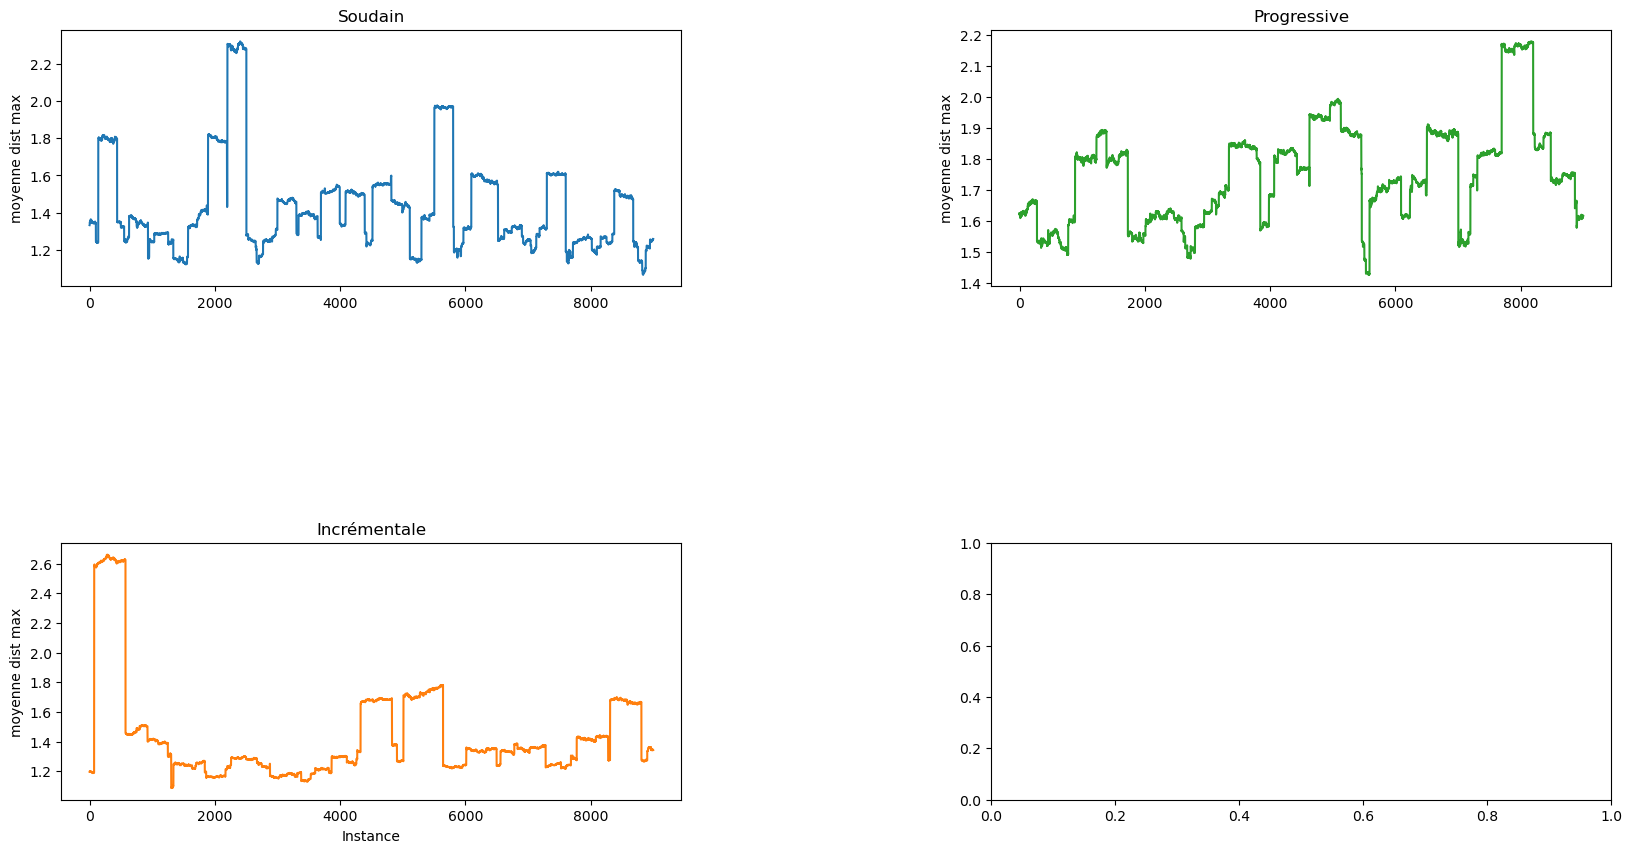

In [57]:
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2,2,hspace = 1 ,wspace = 0.5)
axs = gs.subplots()

axs[0,0].plot(x,abrupt)
axs[0,0].set(title="Soudain",ylabel = "moyenne dist max")

axs[0,1].plot(x,gradual,"tab:green")
axs[0,1].set(title="Progressive",ylabel = "moyenne dist max")


axs[1,0].plot(x,incremental,"tab:orange")
axs[1,0].set(title="Incrémentale",xlabel = "Instance",ylabel = "moyenne dist max")